In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Synthetic data generation

### 1.1 Linear data

In [2]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x: x
    x = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return f(x + b)

def noises(shape , noise_power):
    return np.random.randn(*shape) * noise_power

def dataset(a, b, f = None,  N = 250, x_max = 1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N)) * x_max    
    else:
        x = np.linspace(0, x_max, N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true = np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1, N).T
    y = y_true + noises(y_true.shape, noise_power)

    return y, y_true, np.atleast_2d(x).T

#### 1.1.1

<Axes: >

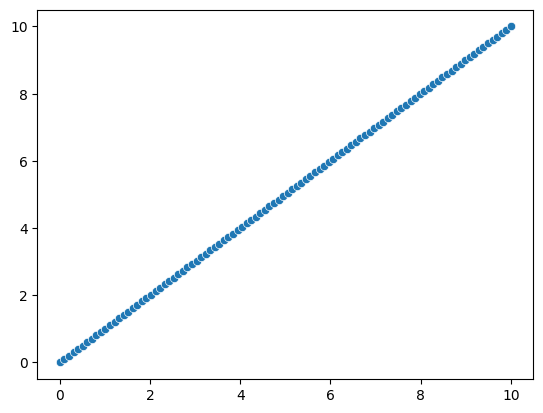

In [51]:
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)

sns.scatterplot(x=x, y=y)
plt.show()

#### 1.1.2

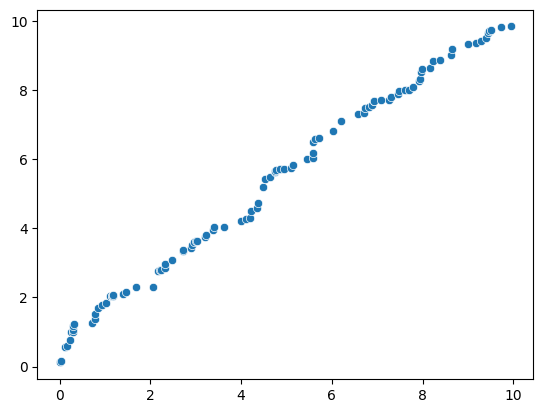

In [52]:
x = np.sort(np.random.uniform(0, 10, 100))
y = np.sort(np.random.uniform(0, 10, 100))

sns.scatterplot(x=x, y=y)
plt.show()

#### 1.1.3

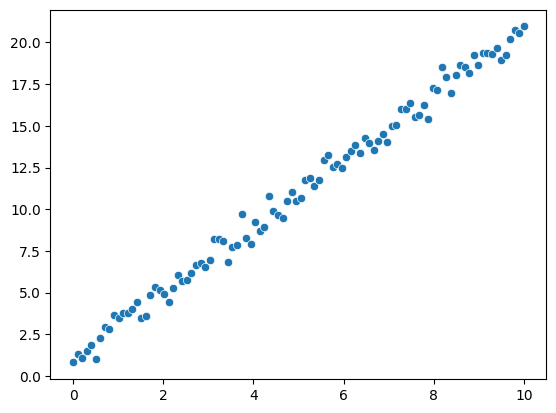

In [56]:
x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 0.5, 100)

sns.scatterplot(x=x, y=y)
plt.show()

#### 1.1.4

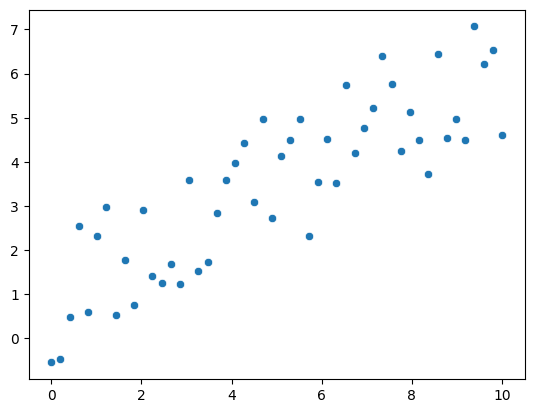

In [59]:
x = np.linspace(0, 10, 50)
y = 0.5 * x + 1 + np.random.normal(0, 1, 50)

sns.scatterplot(x=x, y=y)
plt.show()

### 1.2 polynomial data

#### 1.2.1

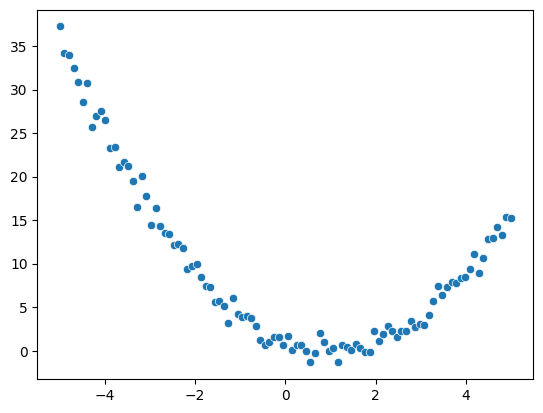

In [61]:
coefficients = [1, -2, 1]
x = np.linspace(-5, 5, 100)
y = np.polyval(coefficients, x) + np.random.normal(0, 1, 100)

sns.scatterplot(x=x, y=y)
plt.show()

#### 1.2.2

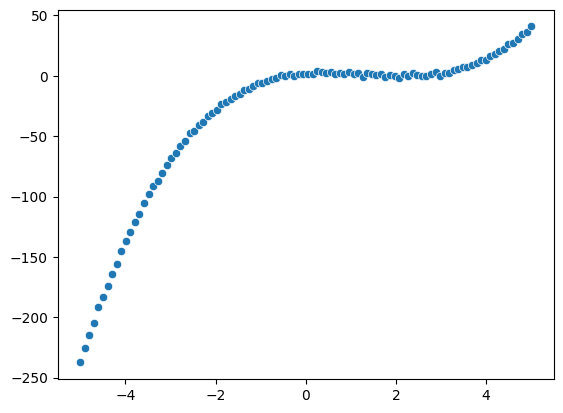

In [72]:
coefficients = [1, -4, 3, 2]
x = np.linspace(-5, 5, 100)
y = np.polyval(coefficients, x) + np.random.normal(0, 1, 100)

sns.scatterplot(x=x, y=y)
plt.show()

#### 1.2.3

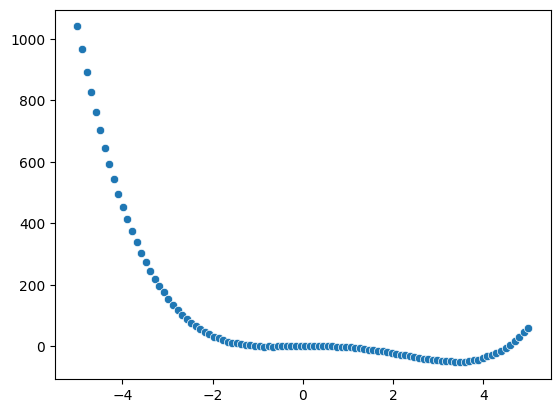

In [70]:
coefficients = [1, -4, -3, 2, 1]
x = np.linspace(-5, 5, 100)
y = np.polyval(coefficients, x) + np.random.normal(0, 1, 100)

sns.scatterplot(x=x, y=y)
plt.show()